In [0]:
#!/usr/bin/env python
"""
Unified Extraction Pipeline

This script processes images for different sections (Survey, BOP, BHA, Personnel,
Time Breakdown) in a sequential and organized manner. The outputs (JSON and CSV)
from each section are aggregated into a single JSON file and a single CSV file.
Logging output is provided, but no image windows are displayed.
"""

import os
import re
import cv2
import math
import pytesseract
import pandas as pd
import logging
import json
from PIL import Image

# ---------------------------------------------------------------------
# 1) Logger Configuration
# ---------------------------------------------------------------------
logger = logging.getLogger("UnifiedExtractor")
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(ch)

# ---------------------------------------------------------------------
# 2) Utility Functions
# ---------------------------------------------------------------------
def dbfs_to_local_path(dbfs_path):
    """Convert a DBFS URI to a local filesystem path."""
    if dbfs_path.startswith("dbfs:/"):
        return "/dbfs/" + dbfs_path[len("dbfs:/"):]
    return dbfs_path

def safe_read_image(img_path):
    """Read an image using OpenCV from a DBFS or local path."""
    local_path = dbfs_to_local_path(img_path)
    logger.info(f"Reading image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
    return img

def read_pil_image(image_path):
    """Read an image using PIL from a DBFS or local path."""
    local_path = dbfs_to_local_path(image_path)
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = Image.open(local_path)
    logger.info(f"PIL image loaded from {local_path} with size {img.size}")
    return img

# ---------------------------------------------------------------------
# 3) Survey Extraction Pipeline
# ---------------------------------------------------------------------
def build_survey_data(roi_texts, headers):
    """Group OCR outputs into rows and return a list of survey dictionaries."""
    tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    lines = []
    for row in rows:
        row.sort(key=lambda r: r[0])
        line = " ".join(r[4] for r in row)
        lines.append(line)
        logger.debug(f"Survey row: {line}")
    data = []
    for line in lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) < len(headers):
            tokens = line.split()
        if len(tokens) >= len(headers):
            data.append({headers[i]: tokens[i] for i in range(len(headers))})
        else:
            logger.warning(f"Survey line skipped (not enough tokens): {line}")
    return data

def process_survey(survey_img_path, debug=False):
    headers = ["MD", "Inclination", "Azimuth", "DLS", "TVD"]
    img = safe_read_image(survey_img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = [(x, y, w, h) for cnt in contours for (x, y, w, h) in [cv2.boundingRect(cnt)]
            if w > 30 and h > 15]
    rois.sort(key=lambda b: (b[1], b[0]))
    roi_texts = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        roi_texts.append((x, y, w, h, text))
    survey_data = build_survey_data(roi_texts, headers)
    # Optionally, sort by MD value (descending)
    survey_data = sorted(survey_data, key=lambda d: float(d["MD"].replace(",", "")) if d["MD"].replace(",", "").isdigit() else 0, reverse=True)
    logger.info("Survey extraction complete.")
    return {"Survey": survey_data}, pd.DataFrame(survey_data)

# ---------------------------------------------------------------------
# 4) BOP Extraction Pipeline
# ---------------------------------------------------------------------
def process_bop(bop_img_path, debug=False):
    pil_img = read_pil_image(bop_img_path)
    ocr_text = pytesseract.image_to_string(pil_img)
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    bop_data = {key: (re.search(regex, ocr_text, re.IGNORECASE).group(1) if re.search(regex, ocr_text, re.IGNORECASE) else "")
                for key, regex in patterns.items()}
    logger.info("BOP extraction complete.")
    return {"BOP": bop_data}, pd.DataFrame(list(bop_data.items()), columns=["Key", "Value"])

# ---------------------------------------------------------------------
# 5) BHA Extraction Pipeline
# ---------------------------------------------------------------------
def extract_bha_data(bha_img_path):
    image = Image.open(dbfs_to_local_path(bha_img_path))
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pattern in patterns.items():
        m = re.search(pattern, ocr_text)
        if m:
            bha_data[key] = m.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
            if remove_key in bha_data:
                detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured = {
        "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
        "Size": bha_data.get("Size", ""),
        "Wt./Ft": bha_data.get("Wt./Ft", ""),
        "Connection": bha_data.get("Connection", ""),
        "ID": bha_data.get("ID", ""),
        "BHA #4": {
            "Drill Bit": bha_data.get("Drill Bit", ""),
            "Motor": bha_data.get("Motor", ""),
            "MWD Tool": bha_data.get("MWD Tool", ""),
            "Monel Collar": bha_data.get("Monel Collar", ""),
            "X-Over": bha_data.get("X-Over", ""),
            "Sub": bha_data.get("Sub", ""),
            "HWDP": bha_data.get("HWDP", ""),
            "Drill Pipe": bha_data.get("Drill Pipe", ""),
            "Reamer": bha_data.get("Reamer", ""),
            "Shock Sub": bha_data.get("Shock Sub", "")
        },
        "Total Length": bha_data.get("Total Length", "")
    }
    logger.info("BHA extraction complete.")
    return {"BHA": structured}, pd.json_normalize(structured)

def process_bha(bha_img_path, debug=False):
    return extract_bha_data(bha_img_path)

# ---------------------------------------------------------------------
# 6) Personnel Extraction Pipeline
# ---------------------------------------------------------------------
def build_personnel_data(roi_results):
    """Group OCR outputs into rows and parse personnel data."""
    # Group by Y coordinate (using a tolerance)
    groups = []
    roi_sorted = sorted(roi_results, key=lambda r: r[1])
    current_group = []
    current_y = None
    for (x, y, w, h, text) in roi_sorted:
        if current_y is None or abs(y - current_y) <= 20:
            current_group.append((x, y, w, h, text))
            if current_y is None:
                current_y = y
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_y = y
    if current_group:
        groups.append(current_group)
    # Parse each group into a row string and extract numeric tokens
    personnel = []
    for group in groups:
        group.sort(key=lambda r: r[0])
        row_text = " ".join(r[4] for r in group).strip()
        if row_text.lower() in {"personnel", "company contractor no. personnel daily hours cumulative hours", "ssn"}:
            continue
        tokens = row_text.split()
        nums = re.findall(r'\d+(?:\.\d+)?', row_text)
        # Assume last three numbers are: No. Personnel, Daily Hours, Cumulative Hours
        if len(nums) >= 3:
            try:
                no_personnel = float(nums[-3])
                daily_hours = float(nums[-2])
                cumulative_hours = float(nums[-1])
            except ValueError:
                continue
            # Remove numeric tokens from text to extract company/contractor info
            pattern = r'\s*' + re.escape(nums[-3]) + r'\s+' + re.escape(nums[-2]) + r'\s+' + re.escape(nums[-1]) + r'\s*$'
            text_only = re.sub(pattern, '', row_text).strip()
        else:
            no_personnel = daily_hours = cumulative_hours = None
            text_only = row_text
        # For simplicity, set Company and Contractor equal to text_only (or further split as needed)
        row_dict = {
            "Company": text_only,
            "Contractor": text_only,
            "No. Personnel": no_personnel,
            "Daily Hours": daily_hours,
            "Cumulative Hours": cumulative_hours
        }
        personnel.append(row_dict)
    return {"Personnel": personnel}

def process_personnel(personnel_img_path, debug=False):
    img = safe_read_image(personnel_img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    # Detect text regions for personnel
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = [(x, y, w, h) for cnt in contours for (x, y, w, h) in [cv2.boundingRect(cnt)]
            if w > 30 and h > 15]
    roi_results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        roi_results.append((x, y, w, h, text))
    personnel_data = build_personnel_data(roi_results)
    logger.info("Personnel extraction complete.")
    return personnel_data, pd.DataFrame(personnel_data["Personnel"])

# ---------------------------------------------------------------------
# 7) Time Breakdown Pipeline
# ---------------------------------------------------------------------
def process_time_breakdown(time_img_path, debug=False):
    img = safe_read_image(time_img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = [(x, y, w, h) for cnt in contours for (x, y, w, h) in [cv2.boundingRect(cnt)]
            if w > 30 and h > 15]
    roi_results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        roi_results.append((x, y, w, h, text))
    # Group OCR results by rows (using a Y-threshold of 20)
    groups = []
    roi_sorted = sorted(roi_results, key=lambda r: r[1])
    current_group = []
    current_y = None
    for (x, y, w, h, text) in roi_sorted:
        if current_y is None or abs(y - current_y) <= 20:
            current_group.append((x, y, w, h, text))
            if current_y is None:
                current_y = y
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_y = y
    if current_group:
        groups.append(current_group)
    # For simplicity, concatenate each group to form a row string
    rows = []
    for group in groups:
        group.sort(key=lambda r: r[0])
        row_text = " ".join(r[4] for r in group)
        # A simple check: if row starts with a time (e.g., "HH:MM"), then accept
        if re.match(r"\d{2}:\d{2}", row_text):
            rows.append(row_text)
    # For this example, we assume each row is already in a parsable format
    # and simply store them in the output.
    time_data = {"Time Breakdown": rows}
    logger.info("Time Breakdown extraction complete.")
    return time_data, pd.DataFrame({"Time Breakdown": rows})

# ---------------------------------------------------------------------
# 8) Main Aggregation and Saving
# ---------------------------------------------------------------------
def main():
    # Define ordered image paths (adjust these paths as needed)
    paths = {
        "Survey": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png",
        "BOP": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png",
        "BHA": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png",
        "Personnel": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png",
        "TimeBreakdown": "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png"
    }

    aggregated_json = {}
    aggregated_dfs = []

    # Process each section in order
    try:
        survey_json, survey_df = process_survey(paths["Survey"], debug=False)
        aggregated_json["Survey"] = survey_json["Survey"]
        survey_df["Section"] = "Survey"
        aggregated_dfs.append(survey_df)
        logger.info("Survey processed successfully.")
    except Exception as e:
        logger.error(f"Error processing Survey: {e}")

    try:
        bop_json, bop_df = process_bop(paths["BOP"], debug=False)
        aggregated_json["BOP"] = bop_json["BOP"]
        bop_df["Section"] = "BOP"
        aggregated_dfs.append(bop_df)
        logger.info("BOP processed successfully.")
    except Exception as e:
        logger.error(f"Error processing BOP: {e}")

    try:
        bha_json, bha_df = process_bha(paths["BHA"], debug=False)
        aggregated_json["BHA"] = bha_json["BHA"]
        bha_df["Section"] = "BHA"
        aggregated_dfs.append(bha_df)
        logger.info("BHA processed successfully.")
    except Exception as e:
        logger.error(f"Error processing BHA: {e}")

    try:
        pers_json, pers_df = process_personnel(paths["Personnel"], debug=False)
        aggregated_json["Personnel"] = pers_json["Personnel"]
        pers_df["Section"] = "Personnel"
        aggregated_dfs.append(pers_df)
        logger.info("Personnel processed successfully.")
    except Exception as e:
        logger.error(f"Error processing Personnel: {e}")

    try:
        tb_json, tb_df = process_time_breakdown(paths["TimeBreakdown"], debug=False)
        aggregated_json["TimeBreakdown"] = tb_json["Time Breakdown"]
        tb_df["Section"] = "TimeBreakdown"
        aggregated_dfs.append(tb_df)
        logger.info("Time Breakdown processed successfully.")
    except Exception as e:
        logger.error(f"Error processing Time Breakdown: {e}")

    # Aggregate DataFrames from all sections into one
    if aggregated_dfs:
        final_df = pd.concat(aggregated_dfs, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    # Save aggregated JSON and CSV to one file each
    output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
    os.makedirs(output_folder, exist_ok=True)
    json_out_path = os.path.join(output_folder, "aggregated_data.json")
    csv_out_path = os.path.join(output_folder, "aggregated_data.csv")
    with open(json_out_path, "w") as f:
        json.dump(aggregated_json, f, indent=4)
    final_df.to_csv(csv_out_path, index=False)
    logger.info(f"Aggregated JSON saved to: {json_out_path}")
    logger.info(f"Aggregated CSV saved to: {csv_out_path}")
    logger.info("Final aggregated DataFrame:")
    print(final_df)

if __name__ == "__main__":
    main()


INFO: Reading image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png
INFO:UnifiedExtractor:Reading image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png
DEBUG: Survey row: SURVEY DATA | SURVEY DATA
DEBUG:UnifiedExtractor:Survey row: SURVEY DATA | SURVEY DATA
DEBUG: Survey row: MD Inclination Azimuth DLS TVD
DEBUG:UnifiedExtractor:Survey row: MD Inclination Azimuth DLS TVD
DEBUG: Survey row: 20,286 89.20 179.98 0.67 10,716
19,906 89.76 179.81 0.15 10,713 20,286 89.20 179.98 0.67 10,716
DEBUG:UnifiedExtractor:Survey row: 20,286 89.20 179.98 0.67 10,716
19,906 89.76 179.81 0.15 10,713 20,286 89.20 179.98 0.67 10,716
DEBUG: Survey row: 20,191 89.23 179.34 0.51 10,715
DEBUG:UnifiedExtractor:Survey row: 20,191 89.23 179.34 0.51 10,715
DEBUG: Survey row: 20,096 89.65 179.59 0.55 10,714
DEBUG:UnifiedExtractor:Survey row: 20,096 89.65 179.59 0.55 10,714
DEBUG: Survey row: 20,001 89.65 180.11 0.34 10,714
DEBUG:UnifiedExtractor:Survey row: 20,001 89.65 180.11 

        MD  ...                                     Time Breakdown
0   20,286  ...                                                NaN
1   20,191  ...                                                NaN
2   20,096  ...                                                NaN
3   20,001  ...                                                NaN
4   SURVEY  ...                                                NaN
5       MD  ...                                                NaN
6      NaN  ...                                                NaN
7      NaN  ...                                                NaN
8      NaN  ...                                                NaN
9      NaN  ...                                                NaN
10     NaN  ...                                                NaN
11     NaN  ...                                                NaN
12     NaN  ...                                                NaN
13     NaN  ...                                               

INFO: Running pipeline: cost_data
INFO: cost_data JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/cost_data.json
INFO: cost_data CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/cost_data.csv
INFO: Running pipeline: well_job
INFO: well_job JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/well_job_data.json
INFO: well_job CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/well_job_data.csv
INFO: Running pipeline: obs_int
INFO: obs_int JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/obs_int_data.json
INFO: obs_int CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/obs_int_data.csv
INFO: Running pipeline: bop
INFO: PIL Image loaded from /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png with size (2502, 71)



--- COST_DATA JSON Output ---
{
    "CostData": "Sample cost data"
}

--- COST_DATA DataFrame ---
           CostData
0  Sample cost data

--- WELL_JOB JSON Output ---
{
    "WellJobData": "Sample well/job data"
}

--- WELL_JOB DataFrame ---
            WellJobData
0  Sample well/job data

--- OBS_INT JSON Output ---
{
    "ObsIntData": "Sample OBS_INT data"
}

--- OBS_INT DataFrame ---
            ObsIntData
0  Sample OBS_INT data


INFO: BOP OCR extraction complete.
INFO: bop JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/bop_data.json
INFO: bop CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/bop_data.csv
INFO: Running pipeline: dir_info
INFO: dir_info JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/dir_info_data.json
INFO: dir_info CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/dir_info_data.csv
INFO: Running pipeline: survey
INFO: Reading image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png



--- BOP JSON Output ---
{
    "BOP": {
        "Last BOP Test Date": "",
        "Last BOP Drill": "",
        "Next BOP Test": ""
    }
}

--- BOP DataFrame ---
                  Key Value
0  Last BOP Test Date      
1      Last BOP Drill      
2       Next BOP Test      

--- DIR_INFO JSON Output ---
{
    "DirInfoData": "Sample Dir Info data"
}

--- DIR_INFO DataFrame ---
            DirInfoData
0  Sample Dir Info data


INFO: Grouped Row 0: SURVEY DATA | SURVEY DATA
INFO: Grouped Row 1: MD Inclination Azimuth DLS TVD
INFO: Grouped Row 2: 20,286 89.20 179.98 0.67 10,716
19,906 89.76 179.81 0.15 10,713 20,286 89.20 179.98 0.67 10,716
INFO: Grouped Row 3: 20,191 89.23 179.34 0.51 10,715
INFO: Grouped Row 4: 20,096 89.65 179.59 0.55 10,714
INFO: Grouped Row 5: 20,001 89.65 180.11 0.34 10,714
INFO: All extracted lines: ['SURVEY DATA | SURVEY DATA', 'MD Inclination Azimuth DLS TVD', '20,286 89.20 179.98 0.67 10,716', '19,906 89.76 179.81 0.15 10,713 20,286 89.20 179.98 0.67 10,716', '20,191 89.23 179.34 0.51 10,715', '20,096 89.65 179.59 0.55 10,714', '20,001 89.65 180.11 0.34 10,714']
INFO: survey JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/survey_data.json
INFO: survey CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/survey_data.csv
INFO: Running pipeline: casing
INFO: casing JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/casing_data.json
INFO: casing CSV data saved to /dbfs/mnt


--- SURVEY JSON Output ---
{
    "SURVEY DATA": []
}

--- SURVEY DataFrame ---
Empty DataFrame
Columns: []
Index: []

--- CASING JSON Output ---
{
    "CasingData": "Sample casing data"
}

--- CASING DataFrame ---
           CasingData
0  Sample casing data


INFO: consumables JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/consumables_data.json
INFO: consumables CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/consumables_data.csv
INFO: Running pipeline: mud
INFO: mud JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/mud_data.json
INFO: mud CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/mud_data.csv
INFO: Running pipeline: bha



--- CONSUMABLES JSON Output ---
{
    "ConsumablesData": "Sample consumables data"
}

--- CONSUMABLES DataFrame ---
           ConsumablesData
0  Sample consumables data

--- MUD JSON Output ---
{
    "MudData": "Sample mud data"
}

--- MUD DataFrame ---
           MudData
0  Sample mud data


ERROR: Error in pipeline 'bha': [Errno 2] No such file or directory: '/Workspace/Repos/divya.dhaipullay@zeussolutionsinc.com/automate_ddr/dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png'
INFO: Running pipeline: pumps
INFO: PIL Image loaded from /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png with size (2502, 276)
INFO: pumps JSON data saved to /dbfs/mnt/mini-proj-dd/final_results/pumps_data.json
INFO: pumps CSV data saved to /dbfs/mnt/mini-proj-dd/final_results/pumps_data.csv
INFO: Running pipeline: personnel
ERROR: Error in pipeline 'personnel': name 'read_cropped_section_image' is not defined
INFO: Running pipeline: time_breakdown
INFO: Reading image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png
INFO: Time Breakdown image loaded successfully.



--- PUMPS JSON Output ---
{
    "Pumps": [
        {
            "Number": "1",
            "Model": "BOMCO",
            "Type": "TRIPLEX",
            "Efficiency": "95"
        }
    ],
    "DrillingCircRates": []
}

--- PUMPS DataFrame ---
  Number  Model     Type Efficiency
0      1  BOMCO  TRIPLEX         95


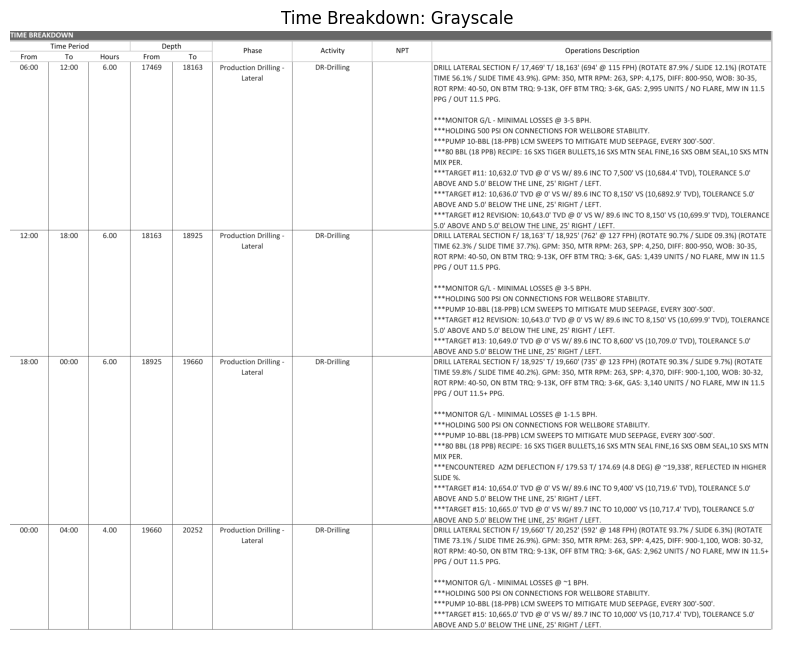

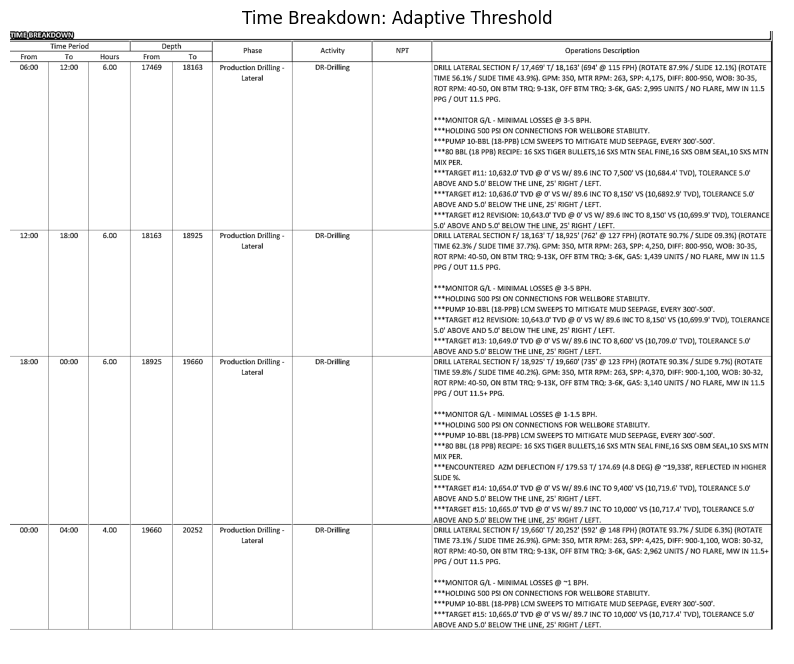

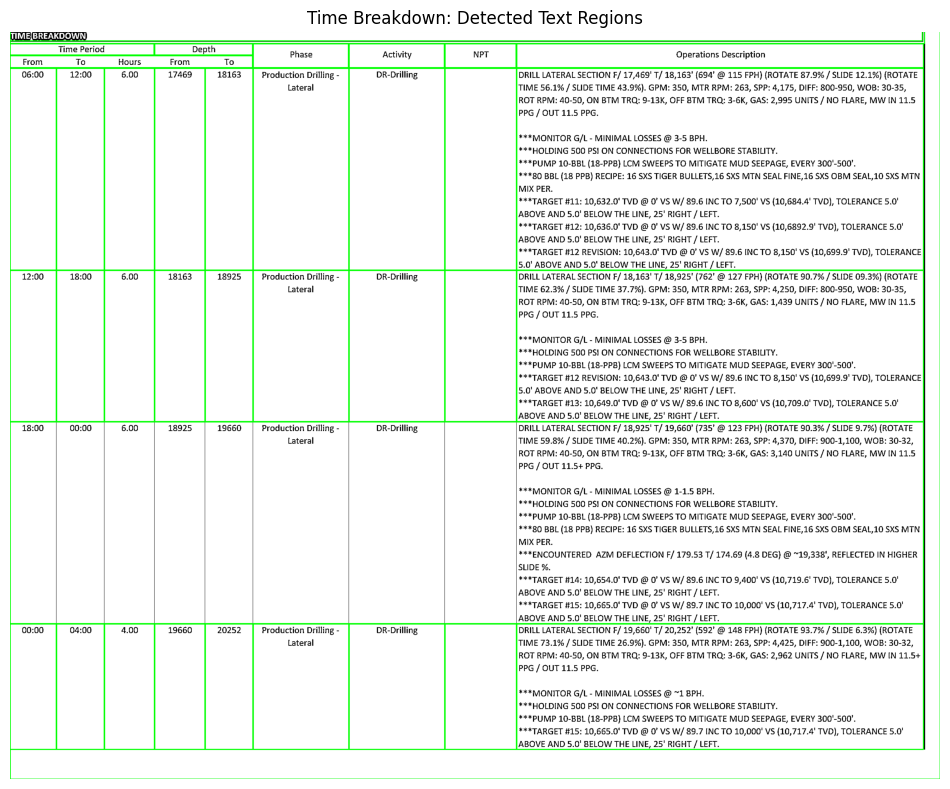

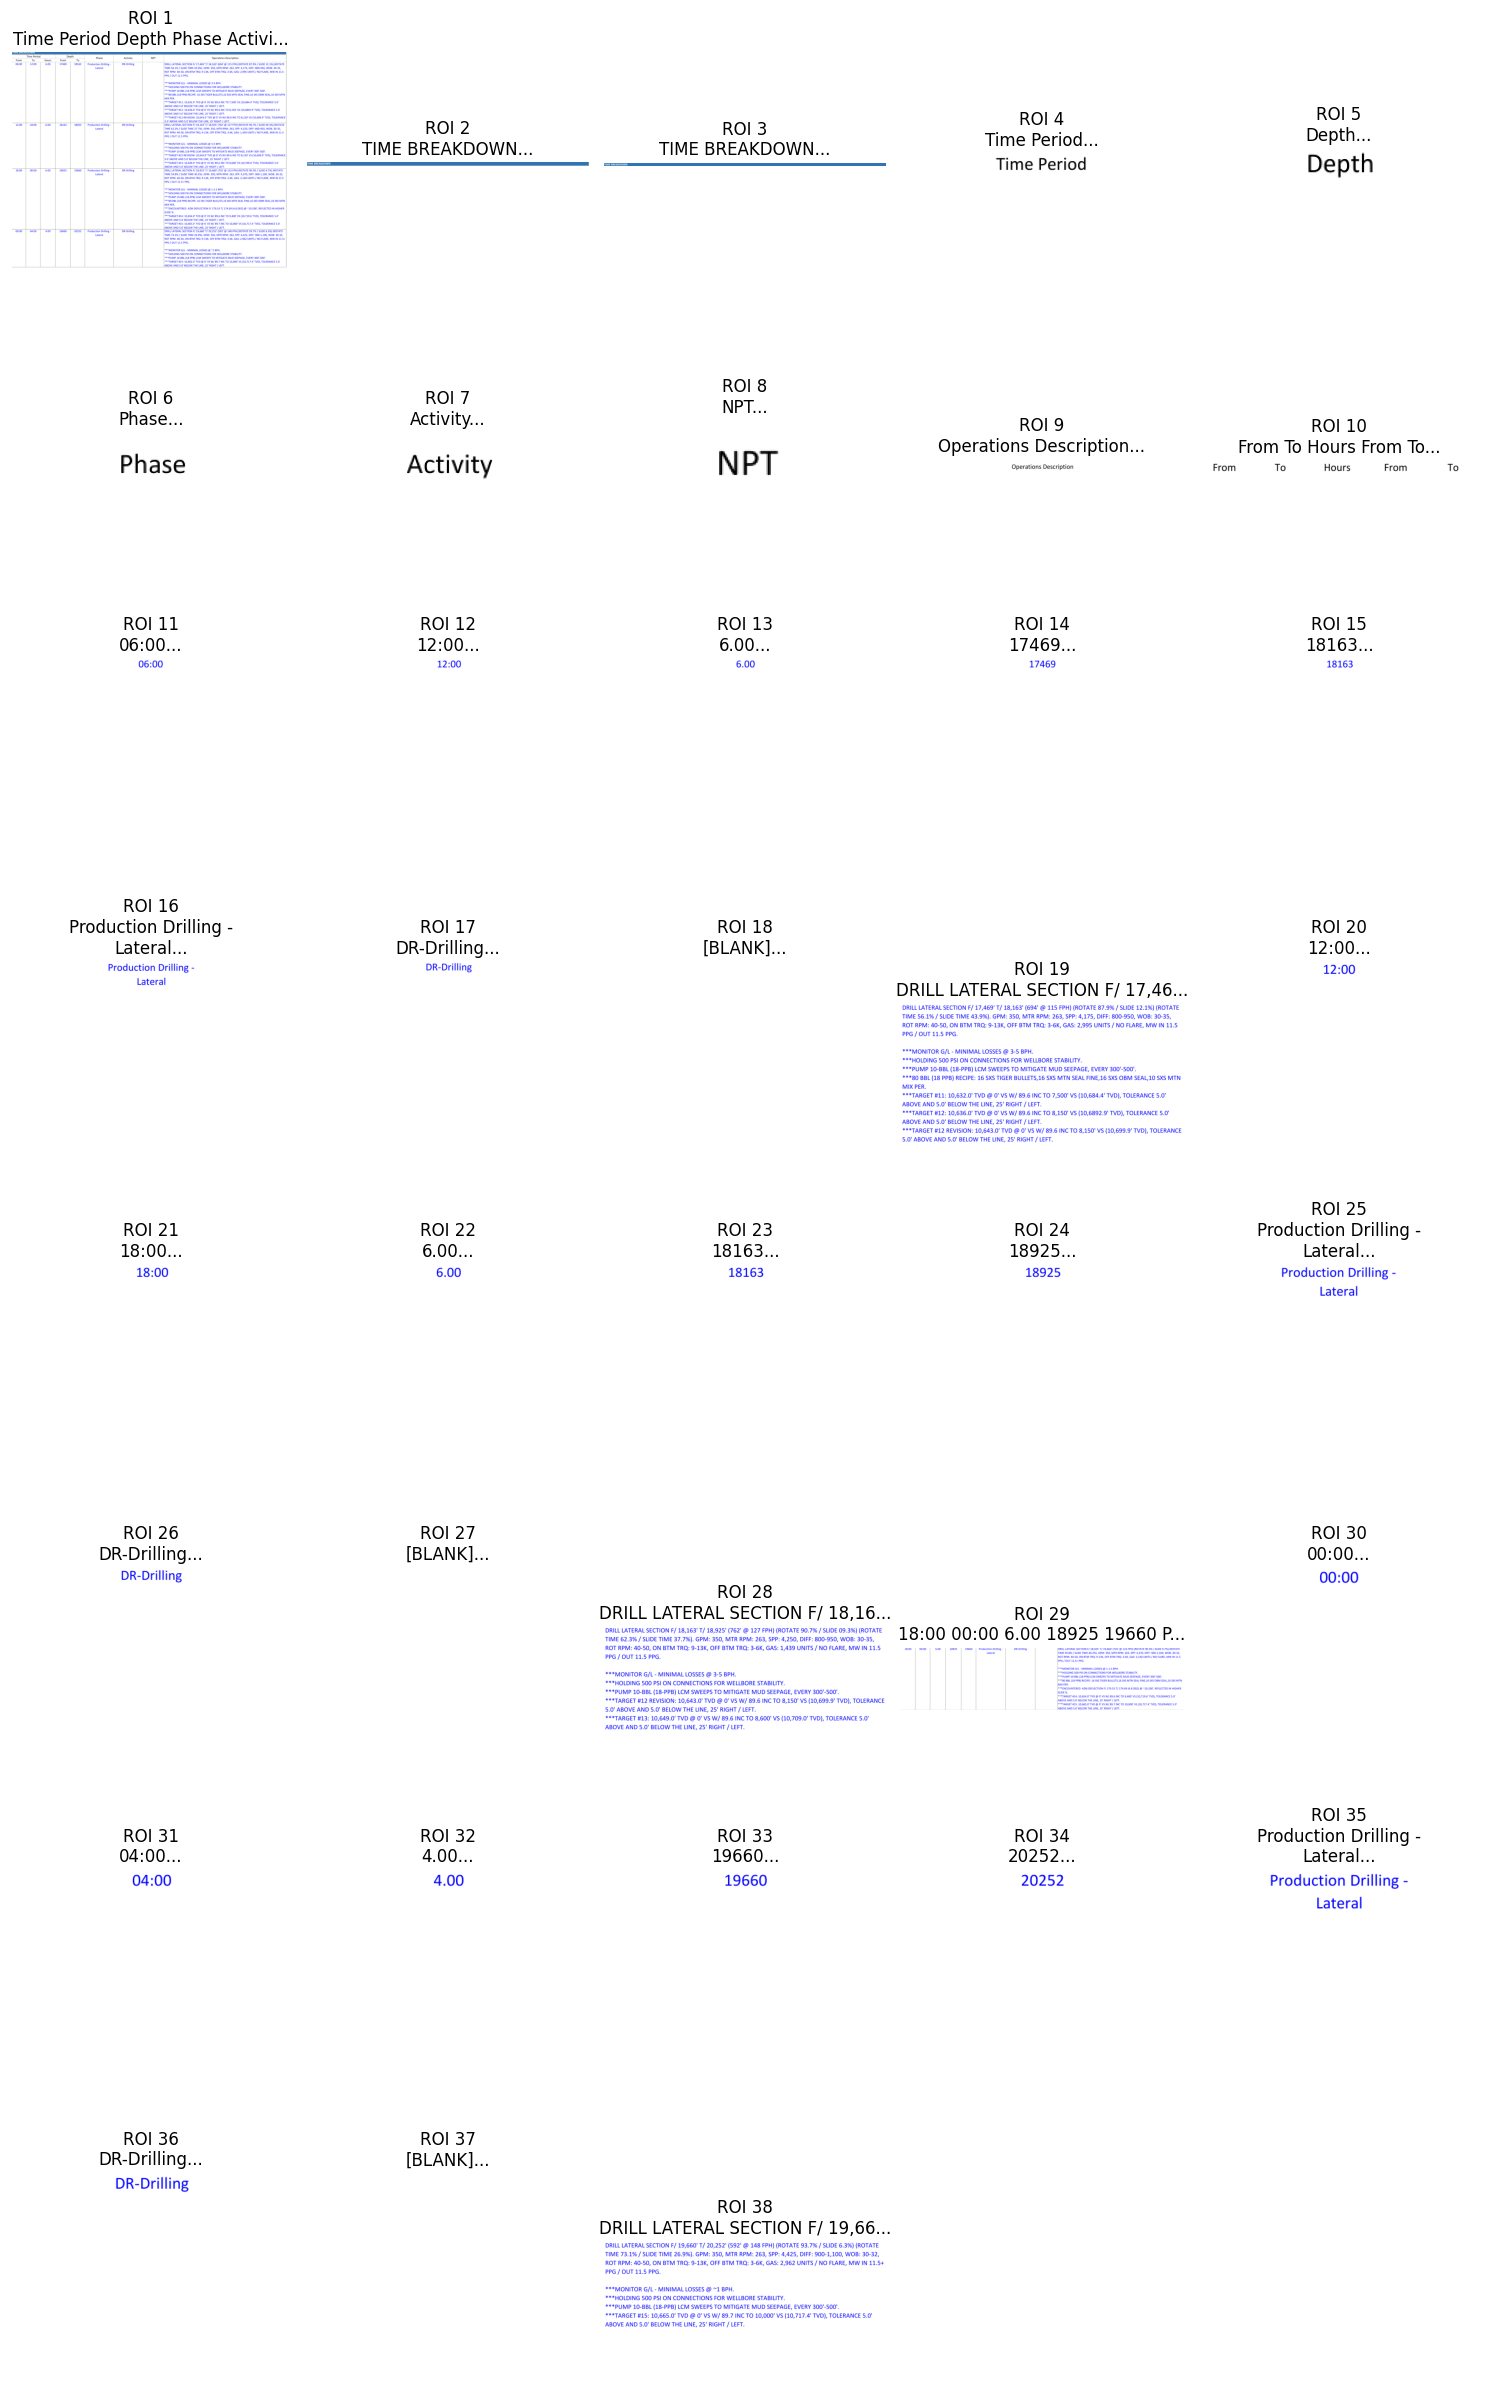

ERROR: Error in pipeline 'time_breakdown': name 'parse_row_text' is not defined
ERROR:UnifiedExtractor:Error in pipeline 'time_breakdown': name 'parse_row_text' is not defined


In [0]:
#!/usr/bin/env python
"""
Unified Extraction Pipeline
---------------------------------
This script implements a complete extraction pipeline that processes various sections
(such as Survey, BOP, Personnel, Time Breakdown, etc.) from provided image paths.
Each section is handled by its own extraction function, and the outputs (JSON and CSV)
are saved and printed. The code is organized into modular functions for maintainability.
"""

import os
import re
import cv2
import math
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------------------------------------------------
# 1) Logger Configuration
# ---------------------------------------------------------------------
logger = logging.getLogger("UnifiedExtractor")
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(ch)

# ---------------------------------------------------------------------
# 2) Utility Functions
# ---------------------------------------------------------------------
def dbfs_to_local_path(dbfs_path):
    """Convert a DBFS URI to a local filesystem path."""
    if dbfs_path.startswith("dbfs:/"):
        return "/dbfs/" + dbfs_path[len("dbfs:/"):]
    return dbfs_path

def safe_read_image(img_path):
    """Read an image using OpenCV from a DBFS or local path."""
    local_path = dbfs_to_local_path(img_path)
    logger.info(f"Reading image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
    return img

def read_pil_image(image_path):
    """Read an image using PIL from a DBFS or local path."""
    local_path = dbfs_to_local_path(image_path)
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = Image.open(local_path)
    logger.info(f"PIL Image loaded from {local_path} with size {img.size}")
    return img

def show_image(title, img, cmap=None, size=(10,10)):
    """Display an image using matplotlib."""
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# 3) Survey Extraction Pipeline
# ---------------------------------------------------------------------
def build_survey_dict_from_rois(roi_texts, expected_headers):
    """Group OCR results into rows and build structured survey data."""
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line)
        logger.info(f"Grouped Row {i}: {line}")
    all_lines = [subline.strip() for line in row_strings for subline in line.split("\n") if subline.strip()]
    logger.info(f"All extracted lines: {all_lines}")
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line) or line.split()
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            continue
        data_lines.append(tokens[:len(expected_headers)])
    survey_list = [{expected_headers[i]: tokens[i] for i in range(len(expected_headers))} for tokens in data_lines]
    return survey_list

def sort_survey_data(survey_list):
    """Sort survey rows by MD value and filter header rows."""
    def md_value(row):
        try:
            return float(row["MD"].replace(",", ""))
        except Exception:
            return 0
    sorted_list = sorted(survey_list, key=md_value, reverse=True)
    return [row for row in sorted_list if not row["MD"].upper().startswith("SURVEY")]

def process_survey(survey_img_path, debug=False):
    """Process the survey image and return structured JSON and DataFrame."""
    expected_headers = ["MD", "Inclination", "Azimuth", "DLS", "TVD"]
    img = safe_read_image(survey_img_path)
    if debug:
        show_image("Original Survey Image", img, size=(12,12))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    if debug:
        show_image("Adaptive Threshold", thresh, cmap="gray")
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = [(x, y, w, h) for cnt in contours for (x, y, w, h) in [cv2.boundingRect(cnt)] if w > 30 and h > 15]
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("Detected Text Regions", debug_img)
    roi_texts = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        roi_texts.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    survey_list = build_survey_dict_from_rois(roi_texts, expected_headers)
    survey_list = sort_survey_data(survey_list)
    final_output = {"SURVEY DATA": survey_list}
    return final_output, pd.DataFrame(survey_list)

# ---------------------------------------------------------------------
# 4) BOP Extraction Pipeline
# ---------------------------------------------------------------------
def perform_ocr_bop(img):
    """Perform OCR on BOP image using pytesseract."""
    text = pytesseract.image_to_string(img)
    logger.info("BOP OCR extraction complete.")
    return text

def extract_bop_info(ocr_text):
    """Extract BOP dates using regex."""
    patterns = {
        "Last BOP Test Date": r"Last BOP Test Date\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Last BOP Drill": r"Last BOP Drill\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})",
        "Next BOP Test": r"Next BOP Test\s*:\s*(\d{1,2}/\d{1,2}/\d{2,4})"
    }
    return {key: (re.search(regex, ocr_text, re.IGNORECASE).group(1) if re.search(regex, ocr_text, re.IGNORECASE) else "")
            for key, regex in patterns.items()}

def process_bop(bop_img_path, debug=False):
    """Process the BOP image and return structured JSON and DataFrame."""
    pil_img = read_pil_image(bop_img_path)
    ocr_text = perform_ocr_bop(pil_img)
    bop_data = extract_bop_info(ocr_text)
    final_output = {"BOP": bop_data}
    return final_output, pd.DataFrame(list(bop_data.items()), columns=["Key", "Value"])

# ---------------------------------------------------------------------
# 5) Personnel Extraction Pipeline
# ---------------------------------------------------------------------
def detect_text_regions_personnel(thresh_img, debug=False):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    logger.debug(f"Detected {len(rois)} personnel text regions.")
    if debug:
        show_image("Detected Personnel Text Regions", debug_img, size=(12,12))
    return rois

def perform_ocr_on_rois_personnel(img, rois, debug=False):
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        logger.debug(f"Personnel ROI ({x}, {y}, {w}, {h}): {text}")
    return results

def group_rois_by_row(roi_results, threshold=20):
    roi_with_center = [(x, y, w, h, text, y + h/2) for (x, y, w, h, text) in roi_results]
    roi_with_center.sort(key=lambda r: r[5])
    groups = []
    current_group = []
    current_center = None
    for roi in roi_with_center:
        x, y, w, h, text, y_center = roi
        if current_center is None or abs(y_center - current_center) < threshold:
            current_group.append((x, y, w, h, text))
            current_center = y_center if current_center is None else current_center
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_center = y_center
    if current_group:
        groups.append(current_group)
    logger.debug(f"Grouped personnel ROIs into {len(groups)} rows.")
    return groups

def preprocess_personnel_data_from_rows(groups):
    personnel_data = []
    header_lines = {"personnel", "company contractor no. personnel daily hours cumulative hours", "ssn"}
    for group in groups:
        group.sort(key=lambda r: r[0])
        row_text = " ".join(r[4] for r in group).strip()
        logger.debug(f"Processing personnel row: '{row_text}'")
        if row_text.lower() in header_lines:
            continue
        tokens = row_text.split()
        numeric_tokens = re.findall(r'\d+(?:\.\d+)?', row_text)
        if tokens[0].lower().startswith("totals"):
            if len(numeric_tokens) >= 2:
                try:
                    daily_hours = float(numeric_tokens[0])
                    cumulative_hours = numeric_tokens[1]  # Can keep as string if desired
                except ValueError as e:
                    logger.error(f"Error parsing Totals row: {row_text} => {e}")
                    continue
                row_dict = {"Company": "", "Contractor": "", "No. Personnel": "Totals",
                            "Daily Hours": daily_hours, "Cumulative Hours": cumulative_hours}
                personnel_data.append(row_dict)
            continue
        if len(numeric_tokens) >= 3:
            try:
                no_personnel = float(numeric_tokens[-3])
                daily_hours = float(numeric_tokens[-2])
                cumulative_hours = float(numeric_tokens[-1])
            except ValueError as e:
                logger.error(f"Error converting numbers in row: {row_text} => {e}")
                continue
            pattern = (r'\s*' + re.escape(numeric_tokens[-3]) +
                       r'\s+' + re.escape(numeric_tokens[-2]) +
                       r'\s+' + re.escape(numeric_tokens[-1]) + r'\s*$')
            text_only = re.sub(pattern, '', row_text).strip()
        elif len(numeric_tokens) == 1:
            try:
                cumulative_hours = float(numeric_tokens[0])
            except ValueError as e:
                logger.error(f"Error converting single number in row: {row_text} => {e}")
                continue
            no_personnel = None
            daily_hours = None
            pattern = r'\s*' + re.escape(numeric_tokens[0]) + r'\s*$'
            text_only = re.sub(pattern, '', row_text).strip()
        else:
            continue
        if "service company" in text_only.lower():
            parts = re.split(r'(?i)service company', text_only, maxsplit=1)
            company = parts[0].strip()
            contractor = "Service Company"
        else:
            company = text_only
            contractor = "Service Company"
        row_dict = {"Company": company, "Contractor": contractor,
                    "No. Personnel": no_personnel, "Daily Hours": daily_hours,
                    "Cumulative Hours": cumulative_hours}
        personnel_data.append(row_dict)
    return {"PERSONNEL": personnel_data}

def process_personnel(personnel_img_path, debug=False):
    img = read_cropped_section_image(personnel_img_path)
    if debug:
        show_image("Original Personnel Image", img, size=(10,10))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    if debug:
        show_image("Thresholded Personnel Image", cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR), size=(8,8))
    rois = detect_text_regions_personnel(thresh_img, debug=debug)
    roi_results = perform_ocr_on_rois_personnel(img, rois, debug=debug)
    grouped_rows = group_rois_by_row(roi_results, threshold=20)
    data_dict = preprocess_personnel_data_from_rows(grouped_rows)
    df = pd.DataFrame(data_dict["PERSONNEL"]) if data_dict["PERSONNEL"] else pd.DataFrame(
        columns=["Company", "Contractor", "No. Personnel", "Daily Hours", "Cumulative Hours"])
    return data_dict, df

# ---------------------------------------------------------------------
# 6) BHA Extraction Pipeline
# ---------------------------------------------------------------------
def extract_bha_data(image_path):
    image = Image.open(image_path)
    ocr_text = pytesseract.image_to_string(image)
    patterns = {
        "Drill Pipe Detail": r"Drill Pipe Detail:\s*([^\n]+)",
        "Size": r"Size:\s*([\d.]+)\b",
        "Wt./Ft": r"Wt\./Ft:\s*([\d.]+)\b",
        "Connection": r"Connection:\s*([\w\d-]+)\b",
        "ID": r"ID:\s*([\d.]+)\b",
        "Drill Bit": r"Drill Bit:\s*([^\n;]+)",
        "Motor": r"Motor:\s*([^\n;]+)",
        "MWD Tool": r"MWD Tool:\s*([^\n;]+)",
        "Monel Collar": r"Monel Collar:\s*([^\n;]+)",
        "X-Over": r"X-Over:\s*([^\n;]+)",
        "Sub": r"Sub:\s*([^\n;]+)",
        "HWDP": r"HWDP:\s*([^\n;]+)",
        "Drill Pipe": r"Drill Pipe:\s*([\d.]+(?:\" DP)?)",
        "Reamer": r"Reamer:\s*([^\n;]+)",
        "Shock Sub": r"Shock Sub:\s*([^\n;]+)",
        "Total Length": r"Total Length:\s*(\d+)\b"
    }
    bha_data = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, ocr_text)
        if match:
            bha_data[key] = match.group(1).strip()
    if "Drill Pipe Detail" in bha_data:
        detail = bha_data["Drill Pipe Detail"]
        for remove_key in ["Size", "Wt./Ft", "Connection", "ID"]:
            if remove_key in bha_data:
                detail = re.sub(rf"{remove_key}:\s*{re.escape(bha_data[remove_key])}", "", detail).strip(",; ")
        bha_data["Drill Pipe Detail"] = detail
    structured_data = {
        "BHA": {
            "Drill Pipe Detail": bha_data.get("Drill Pipe Detail", ""),
            "Size": bha_data.get("Size", ""),
            "Wt./Ft": bha_data.get("Wt./Ft", ""),
            "Connection": bha_data.get("Connection", ""),
            "ID": bha_data.get("ID", ""),
            "BHA #4": {
                "Drill Bit": bha_data.get("Drill Bit", ""),
                "Motor": bha_data.get("Motor", ""),
                "MWD Tool": bha_data.get("MWD Tool", ""),
                "Monel Collar": bha_data.get("Monel Collar", ""),
                "X-Over": bha_data.get("X-Over", ""),
                "Sub": bha_data.get("Sub", ""),
                "HWDP": bha_data.get("HWDP", ""),
                "Drill Pipe": bha_data.get("Drill Pipe", ""),
                "Reamer": bha_data.get("Reamer", ""),
                "Shock Sub": bha_data.get("Shock Sub", "")
            },
            "Total Length": bha_data.get("Total Length", "")
        }
    }
    return structured_data

def process_bha(bha_img_path, debug=False):
    bha_json = extract_bha_data(bha_img_path)
    df = pd.json_normalize(bha_json["BHA"])
    return {"BHA": bha_json["BHA"]}, df

# ---------------------------------------------------------------------
# 7) Time Breakdown Pipeline
# ---------------------------------------------------------------------
def preprocess_image_tb(img, debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("Time Breakdown: Grayscale", gray, cmap="gray", size=(10,10))
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    if debug:
        show_image("Time Breakdown: Adaptive Threshold", thresh, cmap="gray", size=(10,10))
    return thresh

def detect_text_regions_tb(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        show_image("Time Breakdown: Detected Text Regions", debug_img, size=(12,12))
    return rois

def perform_ocr_on_rois_tb(img, rois, debug=True):
    results = []
    n = len(rois)
    if debug and n > 0:
        cols = 5
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten() if rows > 1 else [axes]
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug and i < len(axes):
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[i].imshow(roi_rgb)
            axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
            axes[i].axis("off")
    if debug and n > 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()
    return results

def group_ocr_rows_tb(roi_results, y_threshold=20):
    groups = []
    roi_sorted = sorted(roi_results, key=lambda r: r[1])
    current_group = []
    current_y = None
    for (x, y, w, h, text) in roi_sorted:
        if current_y is None or abs(y - current_y) <= y_threshold:
            current_group.append((x, y, w, h, text))
            current_y = y if current_y is None else current_y
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_y = y
    if current_group:
        groups.append(current_group)
    return groups

def parse_all_rows_from_ocr_groups(roi_results):
    rows = []
    groups = group_ocr_rows_tb(roi_results, y_threshold=20)
    for group in groups:
        group_sorted = sorted(group, key=lambda r: r[0])
        row_text = " ".join([text for (x, y, w, h, text) in group_sorted])
        # Skip header rows if detected
        if any(kw in row_text.upper() for kw in ["TIME PERIOD", "FROM TO", "DEPTH PHASE", "OPERATIONS DESCRIPTION"]):
            continue
        parsed_row = parse_row_text(row_text)
        if parsed_row:
            rows.append(parsed_row)
    return rows

def parse_all_rows_from_text(full_text):
    if re.search(r"\d{2}:\d{2}\s+\d{2}:\d{2}", full_text):
        row_chunks = re.split(r"(?=\d{2}:\d{2}\s+\d{2}:\d{2})", full_text)
        rows = []
        for chunk in row_chunks:
            chunk = chunk.strip()
            if not chunk:
                continue
            row = parse_row_text(chunk)
            if row:
                rows.append(row)
        return rows
    else:
        fallback_row = {
            "From": "",
            "To": "",
            "Hours": "",
            "Depth Start": "",
            "Depth End": "",
            "Phase": "",
            "Activity": "",
            "Operations Description": parse_operations_description(full_text)
        }
        return [fallback_row]

def process_time_breakdown_image(img_path, debug=False):
    img = safe_read_image(img_path)
    thresh_img = preprocess_image_tb(img, debug=debug)
    rois = detect_text_regions_tb(thresh_img, debug=debug)
    roi_results = perform_ocr_on_rois_tb(img, rois, debug=debug)
    rows = parse_all_rows_from_ocr_groups(roi_results)
    if not rows:
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        rows = parse_all_rows_from_text(full_text)
    return rows

def main_time_breakdown_pipeline():
    img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png"
    try:
        img = safe_read_image(img_path)
        logger.info("Time Breakdown image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return None, None
    thresh_img = preprocess_image_tb(img, debug=True)
    rois = detect_text_regions_tb(thresh_img, debug=True)
    roi_results = perform_ocr_on_rois_tb(img, rois, debug=True)
    time_breakdown_list = parse_all_rows_from_ocr_groups(roi_results)
    if not time_breakdown_list:
        logger.warning("No rows detected from ROI grouping. Falling back to full-image OCR.")
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        time_breakdown_list = parse_all_rows_from_text(full_text)
    if not time_breakdown_list:
        logger.error("No rows detected in Time Breakdown.")
        return None, None
    final_output = {"TIME BREAKDOWN": time_breakdown_list}
    df = pd.json_normalize(final_output["TIME BREAKDOWN"])
    logger.info("Final Time Breakdown data:")
    logger.info(json.dumps(final_output, indent=4))
    return final_output, df

# ---------------------------------------------------------------------
# 8) Dummy Pipelines for Other Sections (Cost, Well Job, etc.)
# ---------------------------------------------------------------------
def pipeline_cost_data(dummy_arg=None):
    data = {"CostData": "Sample cost data"}
    return data, pd.DataFrame({"CostData": ["Sample cost data"]})

def process_well_job_info(image_path, dummy_arg=None):
    data = {"WellJobData": "Sample well/job data"}
    return data, pd.DataFrame({"WellJobData": ["Sample well/job data"]})

def process_obs_int(image_path, dummy_arg=None):
    data = {"ObsIntData": "Sample OBS_INT data"}
    return data, pd.DataFrame({"ObsIntData": ["Sample OBS_INT data"]})

def process_dir_info(image_path, dummy_arg=None):
    data = {"DirInfoData": "Sample Dir Info data"}
    return data, pd.DataFrame({"DirInfoData": ["Sample Dir Info data"]})

def pipeline_casing_data(dummy_arg=None):
    data = {"CasingData": "Sample casing data"}
    return data, pd.DataFrame({"CasingData": ["Sample casing data"]})

def pipeline_consumables_data(dummy_arg=None):
    data = {"ConsumablesData": "Sample consumables data"}
    return data, pd.DataFrame({"ConsumablesData": ["Sample consumables data"]})

def pipeline_mud_data(dummy_arg=None):
    data = {"MudData": "Sample mud data"}
    return data, pd.DataFrame({"MudData": ["Sample mud data"]})

def pipeline_pumps_data(dummy_arg=None):
    pumps_img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_12.png"
    pil_img = read_pil_image(pumps_img_path)
    ocr_text = pytesseract.image_to_string(pil_img)
    pumps = [{"Number": "1", "Model": "BOMCO", "Type": "TRIPLEX", "Efficiency": "95"}]
    final_data = {"Pumps": pumps, "DrillingCircRates": []}
    return final_data, pd.DataFrame(pumps)

def extract_bha_data_pipeline(dummy_arg=None):
    bha_img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_11.png"
    return process_bha(bha_img_path, debug=False)

# ---------------------------------------------------------------------
# 9) Pipeline Runner Helper Function
# ---------------------------------------------------------------------
def run_pipeline(name, pipe, debug=False):
    logger.info(f"Running pipeline: {name}")
    try:
        output_json, output_df = pipe["func"](None)
        output_folder = dbfs_to_local_path("dbfs:/mnt/mini-proj-dd/final_results")
        os.makedirs(output_folder, exist_ok=True)
        json_path = os.path.join(output_folder, pipe["json"])
        with open(json_path, "w") as f:
            json.dump(output_json, f, indent=4)
        logger.info(f"{name} JSON data saved to {json_path}")
        csv_path = os.path.join(output_folder, pipe["csv"])
        output_df.to_csv(csv_path, index=False)
        logger.info(f"{name} CSV data saved to {csv_path}")
        print(f"\n--- {name.upper()} JSON Output ---")
        print(json.dumps(output_json, indent=4))
        print(f"\n--- {name.upper()} DataFrame ---")
        print(output_df)
    except Exception as e:
        logger.error(f"Error in pipeline '{name}': {e}")

# ---------------------------------------------------------------------
# 10) Main Pipeline Function with Pipelines Dictionary
# ---------------------------------------------------------------------
def main():
    debug = False  # Set True for detailed logging and image display
    pipelines = {
        "cost_data": {
            "func": pipeline_cost_data,
            "csv": "cost_data.csv",
            "json": "cost_data.json"
        },
        "well_job": {
            "func": lambda d: process_well_job_info("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_2.png", d),
            "csv": "well_job_data.csv",
            "json": "well_job_data.json"
        },
        "obs_int": {
            "func": lambda d: process_obs_int("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_10.png", d),
            "csv": "obs_int_data.csv",
            "json": "obs_int_data.json"
        },
        "bop": {
            "func": lambda d: process_bop("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_8.png", debug),
            "csv": "bop_data.csv",
            "json": "bop_data.json"
        },
        "dir_info": {
            "func": lambda d: process_dir_info("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_5.png", d),
            "csv": "dir_info_data.csv",
            "json": "dir_info_data.json"
        },
        "survey": {
            "func": lambda d: process_survey("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png", debug),
            "csv": "survey_data.csv",
            "json": "survey_data.json"
        },
        "casing": {
            "func": pipeline_casing_data,
            "csv": "casing_data.csv",
            "json": "casing_data.json"
        },
        "consumables": {
            "func": pipeline_consumables_data,
            "csv": "consumables_data.csv",
            "json": "consumables_data.json"
        },
        "mud": {
            "func": pipeline_mud_data,
            "csv": "mud_data.csv",
            "json": "mud_data.json"
        },
        "bha": {
            "func": extract_bha_data_pipeline,
            "csv": "bha_data.csv",
            "json": "bha_data.json"
        },
        "pumps": {
            "func": pipeline_pumps_data,
            "csv": "pumps_data.csv",
            "json": "pumps_data.json"
        },
        "personnel": {
            "func": lambda d: process_personnel("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png", debug),
            "csv": "personnel_data.csv",
            "json": "personnel_data.json"
        },
        "time_breakdown": {
            "func": lambda d: main_time_breakdown_pipeline() if main_time_breakdown_pipeline() else ({"TIME BREAKDOWN": []}, pd.DataFrame()),
            "csv": "time_breakdown_data.csv",
            "json": "time_breakdown_data.json"
        }
    }
    
    for name, pipe in pipelines.items():
        run_pipeline(name, pipe, debug)

if __name__ == "__main__":
    main()
